## Vehicle Detection Project

The goal of the project to develop a pipeline to be able to identify vehicles on an image. First, image features are extracted from the training dataset. We use historgram of oriented gradients to identify color and spatial features of vehicles versus non-vehicles. We then train a `LinearSVC` classifier to detect whether a vehicle is present on a given image.
Next, we use sliding window technique to search for vehicles on an image of a road (to be able to find vehicles in different positions and of different scale). We then average detections from several frames and mark as vehicles hot regions of the image (which have the biggest probability of being a vehicle).

The high-level overview of the project:
- [Dataset exploration](#dataset_exploration)
- [Histogram of Oriented Gradients (HOG)](#hog)
- [Sliding window search](#sliding_window)
- [Video Implementation](#video_pipeline)

## <a id='dataset_exploration'> 0. Dataset exploration</a>

Dataset of vehicles and non-vehicles are provided by Udacity. 
We start with the required imports.


In [1]:
import os
import re
import sys
import cv2
import glob
import numpy as np
import math
import time
import datetime
import pickle
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cross_validation import train_test_split
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import gaussian_filter

# Visualizations will be shown in the notebook.
%matplotlib inline

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We then download the data, and extract the archives in the corresponding directories.

In [2]:
# Load image training dataset
vehicles_url     = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip'
vehicles_arch    = './vehicles.zip'
vehicles_dir     = './vehicles'
vehicles_sub_folders = [f for f in os.listdir(vehicles_dir) if '.DS_Store' not in f]
nonvehicles_url  = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'
nonvehicles_arch = './non-vehicles.zip'
nonvehicles_dir  = './non-vehicles'
nonvehicles_sub_folders = [f for f in os.listdir(nonvehicles_dir) if '.DS_Store' not in f]

if not os.path.isfile(vehicles_arch):
    print("Downloading dataset of vehicles from the web...")
    # download the dataset from the Web
    urllib.request.urlretrieve(vehicles_url, vehicles_arch)
else:
    print("Dataset of vehicles was downloaded before..")

if not os.path.isdir(vehicles_dir):
    print("Extracting the {} archive...".format(vehicles_arch))
    # extract images from the zip archive
    zip_ref = zipfile.ZipFile(vehicles_arch, 'r') 
    zip_ref.extractall('./')
    zip_ref.close()
    print("Extracting vehicles done...")
    
if not os.path.isfile(nonvehicles_arch):
    print("Downloading dataset of non-vehicles from the web...")
    # download the dataset from the Web
    urllib.request.urlretrieve(nonvehicles_url, nonvehicles_arch)
else:
    print("Dataset of non-vehicles was downloaded before..")
    
if not os.path.isdir(nonvehicles_dir):
    print("Extracting the {} archive...".format(nonvehicles_arch))
    # extract images from the zip archive
    zip_ref = zipfile.ZipFile(nonvehicles_arch, 'r') 
    zip_ref.extractall('./')
    zip_ref.close()
    print("Extracting non-vehicles done...")

Dataset of vehicles was downloaded before..
Dataset of non-vehicles was downloaded before..


The datasets are formed as a combination of data from several sources (i.e. from `KITTI` and `GTI` datasets). We now read all image names from all the sub-directories for vehicles and non-vehicles and print the summary.

In [3]:
vehicles_img_names = []
for path, subdirs, files in os.walk(vehicles_dir):
    for name in files:
         if '.DS_Store' not in name:
            vehicles_img_names.append(os.path.join(path, name))

nonvehicles_img_names = []
for path, subdirs, files in os.walk(nonvehicles_dir):
    for name in files:
         if '.DS_Store' not in name:
            nonvehicles_img_names.append(os.path.join(path, name))

In [4]:
print("Number of     vehicle images = {}".format(len(vehicles_img_names)))
print("Number of non-vehicle images = {}".format(len(nonvehicles_img_names)))
print("Image data shape = {}".format(mpimg.imread(vehicles_img_names[1]).shape))

Number of     vehicle images = 8792
Number of non-vehicle images = 8968
Image data shape = (64, 64, 3)


We then print random images of vehicles as well as non-vehicles. Each image in the dataset is a `64x64` color image.

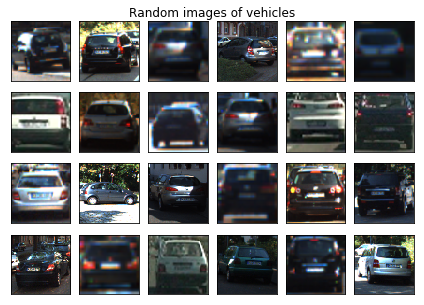

In [5]:
#randomly print `num_images` of vehicles
num_images = 24
NUM_COLUMNS = 6
NUM_ROWS = math.ceil(num_images / NUM_COLUMNS)
rnd_vehicle_img = np.random.choice(vehicles_img_names, num_images, replace=False)
fig = plt.figure(figsize=(6,6))
for idx, el in enumerate(rnd_vehicle_img):
    img = mpimg.imread(el)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Random images of vehicles", y=0.85)
fig.tight_layout(w_pad=0.2, h_pad=-11.0)
plt.show()

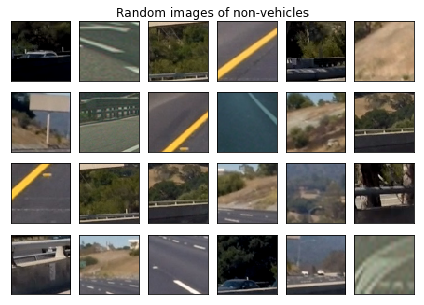

In [6]:
#randomly print `num_images` of non-vehicles
num_images = 24
NUM_COLUMNS = 6
NUM_ROWS = math.ceil(num_images / NUM_COLUMNS)
rnd_nonvehicle_img = np.random.choice(nonvehicles_img_names, num_images, replace=False)
fig = plt.figure(figsize=(6,6))
for idx, el in enumerate(rnd_nonvehicle_img):
    img = mpimg.imread(el)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Random images of non-vehicles", y=0.85)
fig.tight_layout(w_pad=0.2, h_pad=-11.0)
plt.show()

For the bookkeeping, we identify how many images are in each sub-folder:

In [7]:
#for each vehicle (non-vehicle) sub-folder do a dictionary folder --> img names
vehicles_data_subsets = {}
for sub_folder in vehicles_sub_folders:
    sub_folder_path = os.path.join(vehicles_dir, sub_folder)
    vehicles_data_subsets[sub_folder] = glob.glob(sub_folder_path + '/' + '*.png')

nonvehicles_data_subsets = {}
for sub_folder in nonvehicles_sub_folders:
    sub_folder_path = os.path.join(nonvehicles_dir, sub_folder)
    nonvehicles_data_subsets[sub_folder] = glob.glob(sub_folder_path + '/' + '*.png')    

In [8]:
print("Vehicles:")
for key, val in vehicles_data_subsets.items():
    print("Subset: {:20s} #images: {}".format(key, len(val)))

print("\nNon-Vehicles:")
for key, val in nonvehicles_data_subsets.items():
    print("Subset: {:20s} #images: {}".format(key, len(val)))

Vehicles:
Subset: GTI_Left             #images: 909
Subset: GTI_MiddleClose      #images: 419
Subset: GTI_Right            #images: 664
Subset: GTI_Far              #images: 834
Subset: KITTI_extracted      #images: 5966

Non-Vehicles:
Subset: Extras               #images: 5068
Subset: GTI                  #images: 3900


Let us split the data into training, validation and test sets. we use `train_test_split` function from `sklearn.cross_validation` to first split the data into training and (validation and test) sets. We then split validation and test sets. Note, then in order to detect what images are misclassified later, we both divide and shuffle image names. Before, I read images using `cv2.imread`, but in this way after shuffling it is not possible to identify what images were misclassified.

In [9]:
#previously I read image data, (as commented out below) 
#but in this way after shuffling it is not possible to trace images that are misclassified
#vehicles_data = list(map(lambda x : cv2.imread(x), vehicles_img_names))
#nonvehicles_data = list(map(lambda x : cv2.imread(x), nonvehicles_img_names))

seed = int(time.time())

vehicles_train, vehicles_val_test = train_test_split(vehicles_img_names, 
                                                     train_size=0.65, 
                                                     test_size=0.35,
                                                     random_state=seed)
vehicles_val, vehicles_test = train_test_split(vehicles_val_test, 
                                               train_size=0.6, 
                                               test_size=0.4,
                                               random_state=seed)

print("Vehicles training examples       : {}".format(len(vehicles_train)))
print("Vehicles validation examples     : {}".format(len(vehicles_val)))
print("Vehicles testing examples        : {}".format(len(vehicles_test)))

nonvehicles_train, nonvehicles_val_test = train_test_split(nonvehicles_img_names, 
                                                           train_size=0.65, 
                                                           test_size=0.35,
                                                           random_state=seed)
nonvehicles_val, nonvehicles_test = train_test_split(nonvehicles_val_test, 
                                                     train_size=0.6, 
                                                     test_size=0.4,
                                                     random_state=seed)
print("")
print("Non-Vehicles training examples   : {}".format(len(nonvehicles_train)))
print("Non-Vehicles validation examples : {}".format(len(nonvehicles_val)))
print("Non-Vehicles testing examples    : {}".format(len(nonvehicles_test)))

Vehicles training examples       : 5714
Vehicles validation examples     : 1846
Vehicles testing examples        : 1232

Non-Vehicles training examples   : 5829
Non-Vehicles validation examples : 1883
Non-Vehicles testing examples    : 1256


In [10]:
data_pickle = {}
data_pickle["vehicles_train"] = vehicles_train
data_pickle["vehicles_val"] = vehicles_val
data_pickle["vehicles_test"] = vehicles_test
data_pickle["nonvehicles_train"] = nonvehicles_train
data_pickle["nonvehicles_val"] = nonvehicles_val
data_pickle["nonvehicles_test"] = nonvehicles_test
with open("data_pickle_img_names.p", "wb") as p:
    pickle.dump( data_pickle, p )

In [ ]:
with(open('data_pickle_img_names.p', 'rb')) as p:
    data_pickle = pickle.load(p)
    vehicles_train = data_pickle["vehicles_train"]
    vehicles_val = data_pickle["vehicles_val"]
    vehicles_test = data_pickle["vehicles_test"]
    nonvehicles_train = data_pickle["nonvehicles_train"]
    nonvehicles_val = data_pickle["nonvehicles_val"]
    nonvehicles_test = data_pickle["nonvehicles_test"]

## <a id='hog'>1. Histogram of Oriented Gradients (HOG)</a>


We use histogram of oriented gradients, the `hog` function from `skimage.feature` to find orientations of gradients in each cell of a specified size of image. Function `get_hog_features` takes image, size of a cell, cells per block and returns hog features of the image. Function `bin_spatial` takes image and returns spatial features (i.e. contiguous flattened array as image). Function `color_hist` creates color features (i.e. concatenates histograms of all color channels). 

The function `extract_features` combines different feature extraction. Given an image name, we first read the file (we use `cv2.imread` and obtain *BGR* image, but in range 0 to 255. The problem with `matplotlib.image` is that it reads `*.png` files to the domain `[0,1]` and not to `[0, 255]`). We then convert the color space to the specified one, extract spatial and color features, if specified, and return all concatenated features.

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

In [12]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for fname in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(fname)
        # apply color conversion if other than 'RGB'
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

These are example parameters we use to train the classifier. As we see in the implementation for video stream, we use two classifiers. The one mentioned here performs pretty decent.

In [13]:
### Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


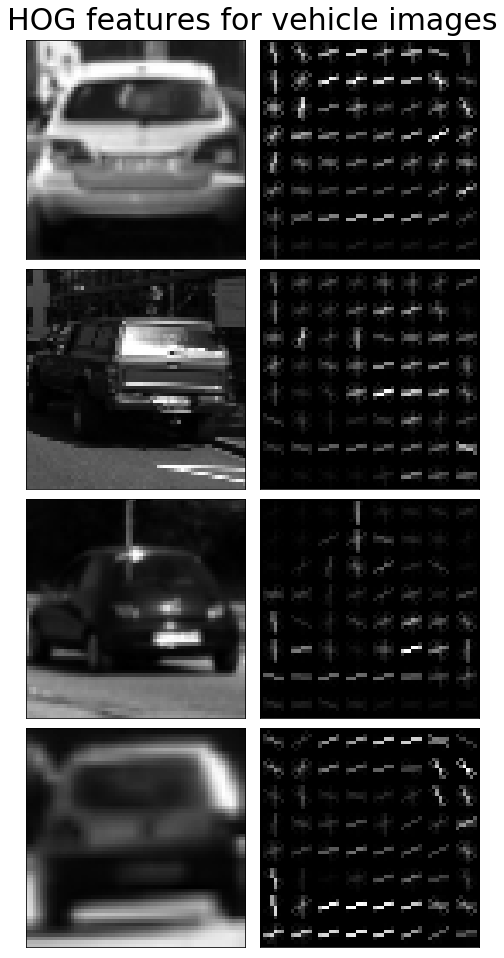

In [23]:
num_images = 4
NUM_COLUMNS = 2
NUM_ROWS = num_images
rnd_vehicle_img = np.random.choice(vehicles_img_names, num_images, replace=False)

fig = plt.figure(figsize=(7,13))
for idx, fname in enumerate(rnd_vehicle_img):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)
    _, hog_image = get_hog_features(img, 
                                    orient=orient,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    vis=True,
                                    feature_vec=hog_feat)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+1)
    ax.imshow(img, interpolation='none', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+2)
    ax.imshow(hog_image, interpolation='none', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(w_pad=+0.3, h_pad=+0.3)
plt.suptitle('HOG features for vehicle images', y=1.02, fontsize=30)
plt.show()

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


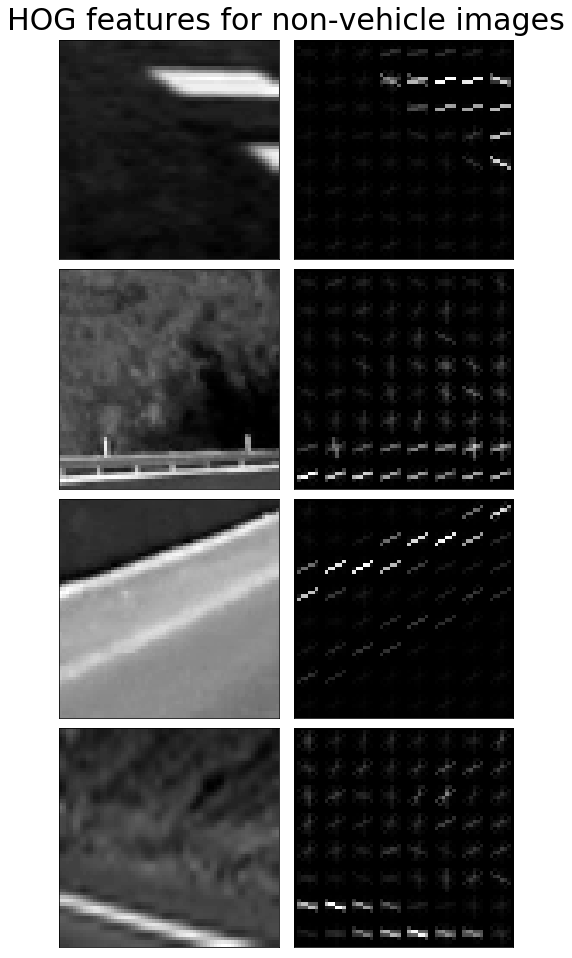

In [24]:
num_images = 4
NUM_COLUMNS = 2
NUM_ROWS = num_images
rnd_nonvehicle_img = np.random.choice(nonvehicles_img_names, num_images, replace=False)

fig = plt.figure(figsize=(7,13))
for idx, fname in enumerate(rnd_nonvehicle_img):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)
    _, hog_image = get_hog_features(img, 
                                    orient=orient,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    vis=True,
                                    feature_vec=hog_feat)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+1)
    ax.imshow(img, interpolation='none', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+2)
    ax.imshow(hog_image, interpolation='none', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(w_pad=+0.3, h_pad=+0.3)
plt.suptitle('HOG features for non-vehicle images', y=1.02, fontsize=30)
plt.show()

For training, validation and test data we now extract features with the specified parameters.

In [25]:
t_start = time.time()
vehicles_training_features = extract_features(vehicles_train, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

vehicles_validation_features = extract_features(vehicles_val, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

vehicles_testing_features = extract_features(vehicles_test, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

nonvehicles_training_features = extract_features(nonvehicles_train, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

nonvehicles_validation_features = extract_features(nonvehicles_val, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

nonvehicles_testing_features = extract_features(nonvehicles_test, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

t_finish = time.time()
print("HOG features extracted in {} s".format(t_finish - t_start))

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


HOG features extracted in 104.59428977966309 s


We now stack all the features into one vector and scale the features. THe purpose of this step to equalize impact of different features.

In [26]:
# Create an array stack of feature vectors
stacked_features = np.vstack((vehicles_training_features,
                              vehicles_validation_features,
                              vehicles_testing_features,
                              nonvehicles_training_features,
                              nonvehicles_validation_features,
                              nonvehicles_testing_features)).astype(np.float64)                        
# Fit a per-column scaler
stacked_features_scaler = StandardScaler().fit(stacked_features)
# Apply the scaler to X
scaled_stacked_features = stacked_features_scaler.transform(stacked_features)

In [27]:
print(stacked_features.shape)
print(scaled_stacked_features.shape)

(17760, 7332)
(17760, 7332)


As we use all available data to scale it, we retrieve back pieces for training, validation and test.

In [28]:
idx_veh_train    = (0,                   len(vehicles_training_features))
idx_veh_val      = (idx_veh_train[1],    idx_veh_train[1] + len(vehicles_validation_features))
idx_veh_test     = (idx_veh_val[1],      idx_veh_val[1] + len(vehicles_testing_features))
idx_nonveh_train = (idx_veh_test[1],     idx_veh_test[1] + len(nonvehicles_training_features))
idx_nonveh_val   = (idx_nonveh_train[1], idx_nonveh_train[1] + len(nonvehicles_validation_features))
idx_nonveh_test  = (idx_nonveh_val[1],   idx_nonveh_val[1] + len(nonvehicles_testing_features))

scaled_vehicles_training_features      = scaled_stacked_features[idx_veh_train[0]:idx_veh_train[1]]
scaled_vehicles_validation_features    = scaled_stacked_features[idx_veh_val[0]:idx_veh_val[1]]
scaled_vehicles_testing_features       = scaled_stacked_features[idx_veh_test[0]:idx_veh_test[1]]
scaled_nonvehicles_training_features   = scaled_stacked_features[idx_nonveh_train[0]:idx_nonveh_train[1]]
scaled_nonvehicles_validation_features = scaled_stacked_features[idx_nonveh_val[0]:idx_nonveh_val[1]]
scaled_nonvehicles_testing_features    = scaled_stacked_features[idx_nonveh_test[0]:idx_nonveh_test[1]]

The classification problem in the project is binary -- either vehicle or non-vehicle. For vehicles our desired output is `1` and for non-vehicles is `0`. We prepare the corresponding `y`-values. We also create a random state and shuffle both features and the corresponding image names, to be able to backtrack what images are classified incorrectly.

In [29]:
y_train = np.hstack((np.ones(len(vehicles_training_features)), 
                     np.zeros(len(nonvehicles_training_features))))
y_val   = np.hstack((np.ones(len(vehicles_validation_features)), 
                     np.zeros(len(nonvehicles_validation_features))))
y_test  = np.hstack((np.ones(len(vehicles_testing_features)), 
                     np.zeros(len(nonvehicles_testing_features))))

X_train = np.vstack((scaled_vehicles_training_features,
                     scaled_nonvehicles_training_features))
X_val   = np.vstack((scaled_vehicles_validation_features,
                     scaled_nonvehicles_validation_features))
X_test  = np.vstack((scaled_vehicles_testing_features,
                     scaled_nonvehicles_testing_features))

X_train_img = np.concatenate((vehicles_train,
                         nonvehicles_train))
X_val_img = np.concatenate((vehicles_val,
                       nonvehicles_val))
X_test_img = np.concatenate((vehicles_test,
                       nonvehicles_test))

random_state=int(time.time())

X_train,y_train = shuffle(X_train,y_train,random_state=random_state)
X_val,y_val = shuffle(X_val,y_val,random_state=random_state)
X_test,y_test = shuffle(X_test,y_test,random_state=random_state)

X_train_img = shuffle(X_train_img, random_state=random_state)
X_val_img = shuffle(X_val_img, random_state=random_state)
X_test_img = shuffle(X_test_img, random_state=random_state)

print("X_train_img: {}\t\tX_train: {}".format(X_train_img.shape, X_train.shape))
print("X_val_img: {}\t\tX_val: {}".format(X_val_img.shape, X_val.shape))
print("X_test_img: {}\t\tX_test: {}".format(X_test_img.shape, X_test.shape))

X_train_img: (11543,)		X_train: (11543, 7332)
X_val_img: (3729,)		X_val: (3729, 7332)
X_test_img: (2488,)		X_test: (2488, 7332)


 ### Training the classifier

We use LinearSVC and train the classifier using prepared training data. We then check our results on validation and test sets.

In [30]:
svc = LinearSVC()

svc.fit(X_train, y_train)
# Check the score of the SVC
validation_acc = svc.score(X_val, y_val)
test_acc = svc.score(X_test, y_test)
print("Validation Accuracy  = {}".format(validation_acc))
print("Test Accuracy        = {}".format(test_acc))

Validation Accuracy  = 0.9924912845266828
Test Accuracy        = 0.9943729903536977


Next, we save the SVC model and the scaler for future in the pickle file.

In [31]:
print(type(svc))

svc_data_pickle = {}
svc_data_pickle["SVC"] = svc
svc_data_pickle["scaler"] = stacked_features_scaler
with open("svc_pickle.p", "wb") as p:
    pickle.dump( svc_data_pickle, p )

<class 'sklearn.svm.classes.LinearSVC'>


Let us explore what the classifier has predicted wrong in the validation set. We identify false positives (images that depict non-vehicles, but classifier marked them as vehicles) and false negatives (images of vehicles that were marked as non-vehicles by the classifier) and print the results.

In [32]:
pred = svc.predict(X_val)
false_pred_idx = np.where(pred != y_val)[0]
# false negative -- failed to detect a vehicle when there was one
pred_false_neg_idx = [f for f in false_pred_idx if pred[f] == 0 ]
#false positive -- detected vehicle for non-vehicle image
pred_false_pos_idx = [f for f in false_pred_idx if pred[f] == 1 ]

print("# misclassified images: {}  of {}".format(len(false_pred_idx), len(y_val)))
print("# false positives:      {}".format(len(pred_false_pos_idx)))
print("# false negatives:      {}\n".format(len(pred_false_neg_idx)))

print("incorrect predictions: {}".format(len(false_pred_idx)))
print("false negatives: {}".format(pred_false_neg_idx))
print("false positives: {}".format(pred_false_pos_idx))

# misclassified images: 28  of 3729
# false positives:      8
# false negatives:      20

incorrect predictions: 28
false negatives: [133, 194, 628, 740, 880, 945, 1154, 1371, 1428, 2068, 2137, 2189, 2335, 2401, 2686, 2778, 3132, 3303, 3571, 3580]
false positives: [348, 484, 512, 1471, 1734, 3041, 3532, 3691]


For incorrect predictions, we also identify image names and display the corresponding image.

./vehicles/GTI_Left/image0321.png
./vehicles/KITTI_extracted/5935.png
./vehicles/KITTI_extracted/4281.png
./vehicles/GTI_Left/image0457.png
./vehicles/GTI_Right/image0326.png
./vehicles/GTI_MiddleClose/image0177.png
./vehicles/GTI_Right/image0478.png
./vehicles/KITTI_extracted/3980.png
./vehicles/GTI_Far/image0918.png
./vehicles/GTI_Left/image0558.png
./vehicles/GTI_Right/image0654.png
./vehicles/KITTI_extracted/381.png
./vehicles/GTI_Right/image0043.png
./vehicles/KITTI_extracted/2845.png
./vehicles/GTI_Left/image0946.png
./vehicles/GTI_Right/image0721.png
./vehicles/GTI_Far/image0973.png
./vehicles/KITTI_extracted/2667.png
./vehicles/GTI_Right/image0614.png
./vehicles/KITTI_extracted/3029.png


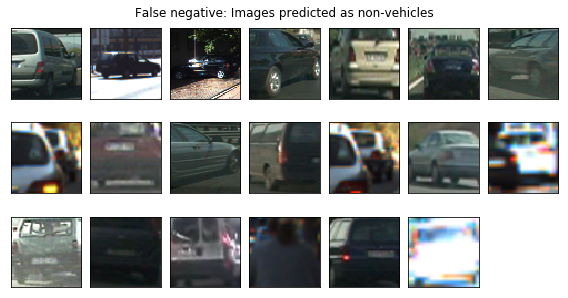

In [33]:
#plot false negatives
num_images = len(pred_false_neg_idx)
NUM_COLUMNS = 7
NUM_ROWS = math.ceil(num_images / NUM_COLUMNS)
fig = plt.figure(figsize=(8,6))
for idx, el in enumerate(pred_false_neg_idx):
    print(X_val_img[el])
    img = cv2.imread(X_val_img[el])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("False negative: Images predicted as non-vehicles", y=0.85)
fig.tight_layout(w_pad=0.2, h_pad=-11.0)
plt.show()

./non-vehicles/Extras/extra2424.png
./non-vehicles/GTI/image2297.png
./non-vehicles/GTI/image2676.png
./non-vehicles/Extras/extra136.png
./non-vehicles/Extras/extra1741.png
./non-vehicles/Extras/extra187.png
./non-vehicles/GTI/image2204.png
./non-vehicles/GTI/image954.png


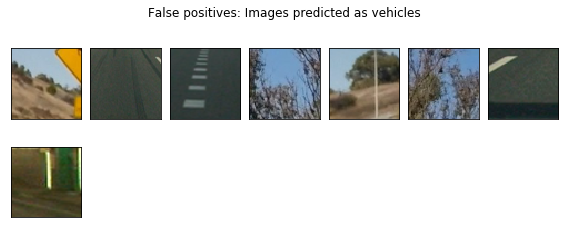

In [34]:
#plot false positives
num_images = len(pred_false_pos_idx)
NUM_COLUMNS = 7
NUM_ROWS = math.ceil(num_images / NUM_COLUMNS)
fig = plt.figure(figsize=(8,5))
for idx, el in enumerate(pred_false_pos_idx):
    print(X_val_img[el])
    img = cv2.imread(X_val_img[el])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("False positives: Images predicted as vehicles", y=0.85)
fig.tight_layout(w_pad=0.2, h_pad=-11.0)
plt.show()

## <a id='sliding_window'>2. Sliding Window Search</a>

When camera is mounted on a vehicle and records an image of a road, vehicles appear in different locations of the frame and in a different scale (depending on a distance). To account for this, we use sliding window search, where image is split in cells of different size and location (alternatively, several windows of different size are slided on an image and vehicle detection is performed in each image.

This section is dedicated to implementing the sliding window search. The function `slide_window` returns a list of windows that are within the pre-specified start and stop coordinates in `x` and `y` and overlap by a given ratio. The function `draw_boxes` gets an image and a list of boxes coordinates and draws rectangles with the specified coordinates. `single_img_features` extracts features from a patch of an image. `search_windows` returns a list of windows, for which the classifier predicted presense of *vehicles*.

In [35]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Let's read test images of a road. For these we will apply our `search_windows` function.

In [36]:
images_road = glob.glob("test_images/*")
images_road.sort()
for img in images_road:
    print(img)

test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


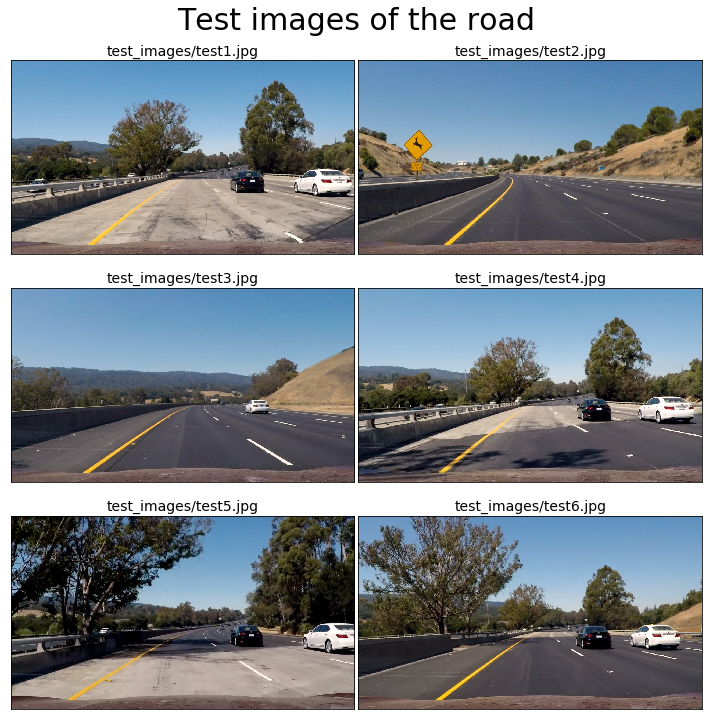

In [37]:
NUM_COLUMNS = 2
NUM_ROAD_IMG = len(images_road)
NUM_ROWS = math.ceil(NUM_ROAD_IMG / NUM_COLUMNS)
fig = plt.figure(figsize=(10,10))
for idx, fname in enumerate(images_road):
    img = mpimg.imread(fname)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_title(fname,  fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(w_pad=-0.3, h_pad=-1.0)
plt.suptitle('Test images of the road', y=1.02, fontsize=30)
plt.show()

Since it only make sense to search for vehicles in the region of a road, we define a method `get_window_coordinates` that identifies coordinates to restricts the search to the specified region of an image.

In [38]:
def get_window_coordinates(img, draw=False):
    w_size = [64, 128, 192, 256]
    w_overlap = 0.8
    xy_window = [ (w, w) for w in w_size ]
    xy_overlap = [ (w_overlap, w_overlap) for _ in w_size ]
    x_start_stop = [ [None, None] for _ in w_size ]
    y_top = [ 410, 400, 395, 405 ]
    y_start_stop = [[y, int(y+w/2)] for y,w in zip(y_top, w_size)]
    return x_start_stop, y_start_stop, xy_window, xy_overlap

image = mpimg.imread(images_road[4])
x_start_stop, y_start_stop, xy_window, xy_overlap = get_window_coordinates(image, draw=True)

print("x_start_stop : {}".format(x_start_stop))
print("y_start_stop : {}".format(y_start_stop))
print("xy_window    : {}".format(xy_window))
print("xy_overlap   : {}".format(xy_overlap))

x_start_stop : [[None, None], [None, None], [None, None], [None, None]]
y_start_stop : [[410, 442], [400, 464], [395, 491], [405, 533]]
xy_window    : [(64, 64), (128, 128), (192, 192), (256, 256)]
xy_overlap   : [(0.8, 0.8), (0.8, 0.8), (0.8, 0.8), (0.8, 0.8)]


The method `detect_vehicles` does the following: for each window size, start and stop coordinates, overlap ratio search for vehicles and obtain *on_windows* (where the classifier predicted presence of vehicle). We also draw *all_windows*, in which we searched for vehicles. We return two images, the one on which *on_windows* are shown, and the other one on which *all_windows* are shown.

In [39]:
def detect_vehicles(image):
    draw_image = np.copy(image)
    on_windows = []
    all_windows = []

    window_params = list(zip(x_start_stop, y_start_stop, xy_window, xy_overlap))
    for el_x_start_stop, el_y_start_stop, el_xy_window, el_xy_overlap in window_params:
        windows = slide_window(image, 
                               x_start_stop = el_x_start_stop, 
                               y_start_stop = el_y_start_stop, 
                               xy_window = el_xy_window, 
                               xy_overlap = el_xy_overlap)

        all_windows.extend([windows])

        curr_on_windows = search_windows(image, 
                                   windows=windows, 
                                   clf=svc, 
                                   scaler=stacked_features_scaler, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size, 
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)   
        on_windows.extend(curr_on_windows)

    window_img = draw_boxes(draw_image, on_windows, color=(0, 255, 255), thick=4)                    

    colors = [ (255, 0, 0), 
               (0, 255, 0), 
               (0, 0, 255), 
               (0, 255, 255) ]
    for idx, el_windows in enumerate(all_windows):
        draw_image = draw_boxes(draw_image, el_windows, color=colors[idx % len(colors)], thick=6)     
    
    return window_img, draw_image

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


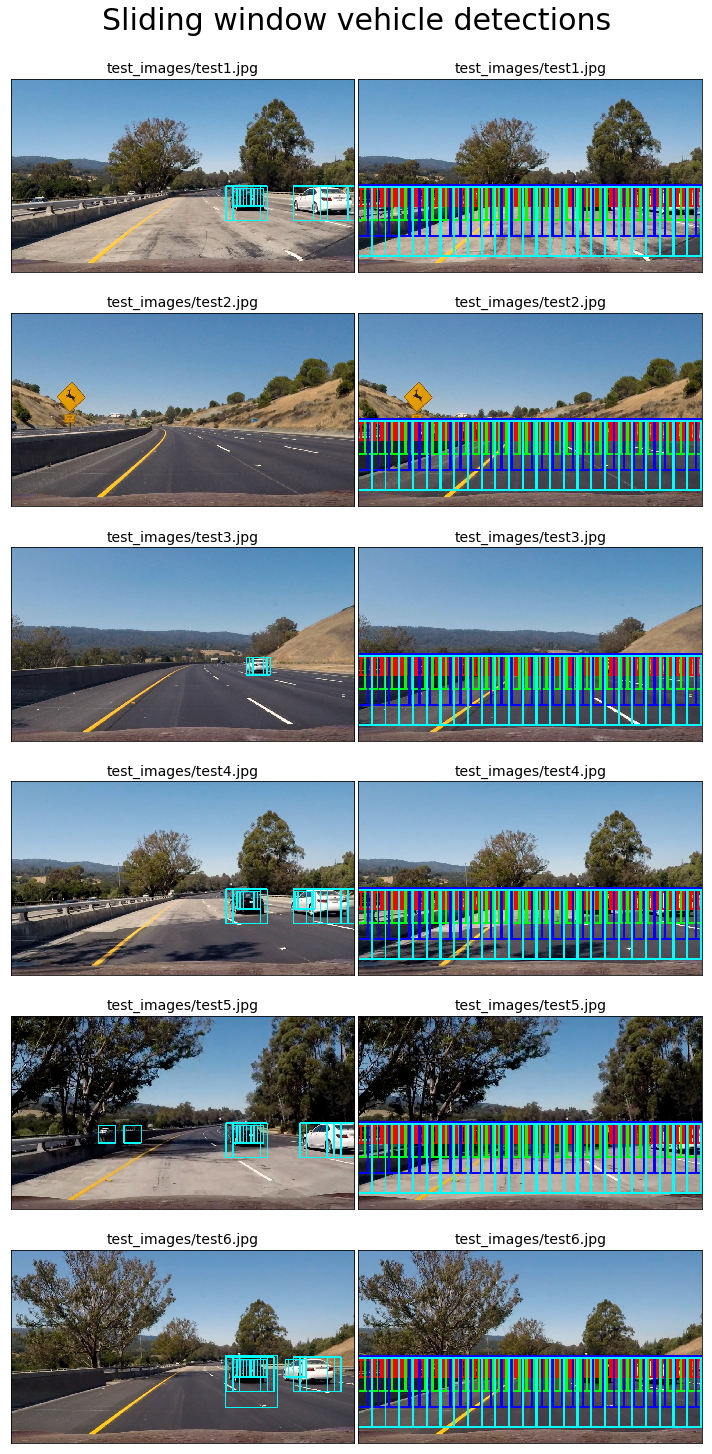

In [40]:
NUM_COLUMNS = 2
NUM_ROAD_IMG = len(images_road)
NUM_ROWS = NUM_ROAD_IMG
fig = plt.figure(figsize=(10,20))
for idx, fname in enumerate(images_road):
    img = mpimg.imread(fname)
    window_img, draw_image = detect_vehicles(img)
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+1)
    ax.imshow(window_img, interpolation='none')
    ax.set_title(fname,  fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,NUM_COLUMNS*idx+2)
    ax.imshow(draw_image, interpolation='none')
    ax.set_title(fname,  fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(w_pad=-0.3, h_pad=-1.0)
plt.suptitle('Sliding window vehicle detections', y=1.02, fontsize=30)
plt.show()

As seen from the images above, the classifier also detects false positives. In order to eliminate those, we add one more dimension (the so-called *heat*) to identify regions with the highest probability of vehicles. Function `add_heat` adds 1 for each box where classifier detected vehicles. Since vehicles are detected in overlapping windows (more likely then false-positives), the regions of vehicles are likely to have more heat, than sporadic false-positive outcomes. Function `apply_threshold` aims to eliminate false positives by zeroing out the heat pixels that are less then a specified bound. Function `draw_labeled_bboxes` takes image and labels and draws rectangles on the image for each label.

In [41]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

We then draw the heatmap for the test road image:

/home/selyunin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


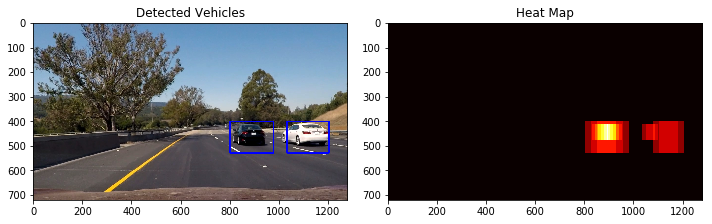

In [42]:
# Read in image similar to one shown above 
image = mpimg.imread(images_road[5])
heat = np.zeros_like(image[:,:,0]).astype(np.float)


draw_image = np.copy(image)
on_windows = []
all_windows = []

window_params = list(zip(x_start_stop, y_start_stop, xy_window, xy_overlap))
for el_x_start_stop, el_y_start_stop, el_xy_window, el_xy_overlap in window_params:
    windows = slide_window(image, 
                           x_start_stop = el_x_start_stop, 
                           y_start_stop = el_y_start_stop, 
                           xy_window = el_xy_window, 
                           xy_overlap = el_xy_overlap)

    all_windows.extend([windows])

    curr_on_windows = search_windows(image, 
                               windows=windows, 
                               clf=svc, 
                               scaler=stacked_features_scaler, 
                               color_space=color_space, 
                               spatial_size=spatial_size, 
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)   
    on_windows.extend(curr_on_windows)



box_list = on_windows

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Detected Vehicles')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

## <a id='video_pipeline'>Video Implementation</a>


For video implementation, I re-implemented (i) data preparation and classifier training and (ii) vehicle detection modules into two parts: the classifier part and video processing system part. 

First, given the parameters of features to use, the LinearSVC classifier is trained and evaluated, with the classifier, parameters and scaler stored in a pickle file.

Second, video processing system reads (possibly with more then one classifier) pickle files, load pre-trained classifiers and performs vehicle search in each image frame. To filter out false positives, I first threshold detected boxes, then used fixes size queue of `N` consecutive windows and then threshold the result again. This two way thresholding allows to reduce amount of false, positives, but false positives can occasionally appear on the final video. In my opinion this is in match with the project rubric "Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)".

### Classifier subsystem

The classifier subsystem is essentially the `ClassifierFit` class, which accepts a dictionary of parameters, extracts features taking into account parameters, and trains a LinearSVC. The classifier, scaler, and the parameters are then saved in a pickle file. Below, we train two classifiers, one for `YUV` and one for `YCrCb` color spaces.




In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque, OrderedDict

In [44]:
class ClassifierFit():
    def __init__(self, *args, **kwargs):
        self.params = {}
        self.set_params(args[0])
        self.get_training_data()
        self.get_img_names()
        self.print_img_stats()
        self.split_train_test_data()
        self.print_train_test_stats()
        self.compute_features()
        self.scale_features()
        self.fit_classifier()
        self.store_classifier()
        
    def fit_classifier(self):
        print("Fitting data to LinearSVC...")
        
        self.svc = LinearSVC()

        self.svc.fit(self.X_train, self.y_train)
        # Check the score of the SVC
        validation_acc = self.svc.score(self.X_val, self.y_val)
        test_acc = self.svc.score(self.X_test, self.y_test)
        print("Validation Accuracy  = {}".format(validation_acc))
        print("Test Accuracy        = {}".format(test_acc))
        
    def store_classifier(self):
        self.pickle_name = "svc_pickle_{}_{}.p".format(self.params['color_space'], self.params['orient'])
        svc_data_pickle = {}
        svc_data_pickle["SVC"] = self.svc
        svc_data_pickle["scaler"] = self.scaler
        svc_data_pickle["params"] = self.params
        with open(self.pickle_name, "wb") as p:
            pickle.dump( svc_data_pickle, p )
        print("Classifier, scaler and params are saved in {} file".format(self.pickle_name))
    
    def set_params(self, new_params):
        self.params['color_space'] = new_params['color_space']
        self.params['orient'] = new_params['orient']
        self.params['pix_per_cell'] = new_params['pix_per_cell']
        self.params['cell_per_block'] = new_params['cell_per_block']
        self.params['hog_channel'] = new_params['hog_channel']
        self.params['spatial_size'] = new_params['spatial_size']
        self.params['hist_bins'] = new_params['hist_bins']
        self.params['spatial_feat'] = new_params['spatial_feat']
        self.params['hist_feat'] = new_params['hist_feat']
        self.params['hog_feat'] = new_params['hog_feat']
        
    def compute_features(self):
        t_start = time.time()
        print("Starting HOG feature extraction: {} s".format(t_start))
        self.vehicles_training_features = self.extract_features(self.vehicles_train, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        self.vehicles_validation_features = self.extract_features(self.vehicles_val, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        self.vehicles_testing_features = self.extract_features(self.vehicles_test, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        self.nonvehicles_training_features = self.extract_features(self.nonvehicles_train, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        self.nonvehicles_validation_features = self.extract_features(self.nonvehicles_val, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        self.nonvehicles_testing_features = self.extract_features(self.nonvehicles_test, 
                                       color_space=self.params['color_space'], 
                                       spatial_size=self.params['spatial_size'], 
                                       hist_bins=self.params['hist_bins'], 
                                       orient=self.params['orient'], 
                                       pix_per_cell=self.params['pix_per_cell'], 
                                       cell_per_block=self.params['cell_per_block'], 
                                       hog_channel=self.params['hog_channel'], 
                                       spatial_feat=self.params['spatial_feat'], 
                                       hist_feat=self.params['hist_feat'], 
                                       hog_feat=self.params['hog_feat'])
        
        t_finish = time.time()
        print("HOG features extracted in {} s".format(t_finish - t_start))
        
    def scale_features(self):
        # Create an array stack of feature vectors
        self.stacked_features = np.vstack((self.vehicles_training_features,
                                      self.vehicles_validation_features,
                                      self.vehicles_testing_features,
                                      self.nonvehicles_training_features,
                                      self.nonvehicles_validation_features,
                                      self.nonvehicles_testing_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self.scaler = StandardScaler().fit(self.stacked_features)
        # Apply the scaler to X
        self.scaled_stacked_features = self.scaler.transform(self.stacked_features)
    
        idx_veh_train    = (0,                   len(self.vehicles_training_features))
        idx_veh_val      = (idx_veh_train[1],    idx_veh_train[1] + len(self.vehicles_validation_features))
        idx_veh_test     = (idx_veh_val[1],      idx_veh_val[1] + len(self.vehicles_testing_features))
        idx_nonveh_train = (idx_veh_test[1],     idx_veh_test[1] + len(self.nonvehicles_training_features))
        idx_nonveh_val   = (idx_nonveh_train[1], idx_nonveh_train[1] + len(self.nonvehicles_validation_features))
        idx_nonveh_test  = (idx_nonveh_val[1],   idx_nonveh_val[1] + len(self.nonvehicles_testing_features))
        
        self.scaled_vehicles_training_features      = self.scaled_stacked_features[idx_veh_train[0]:idx_veh_train[1]]
        self.scaled_vehicles_validation_features    = self.scaled_stacked_features[idx_veh_val[0]:idx_veh_val[1]]
        self.scaled_vehicles_testing_features       = self.scaled_stacked_features[idx_veh_test[0]:idx_veh_test[1]]
        self.scaled_nonvehicles_training_features   = self.scaled_stacked_features[idx_nonveh_train[0]:idx_nonveh_train[1]]
        self.scaled_nonvehicles_validation_features = self.scaled_stacked_features[idx_nonveh_val[0]:idx_nonveh_val[1]]
        self.scaled_nonvehicles_testing_features    = self.scaled_stacked_features[idx_nonveh_test[0]:idx_nonveh_test[1]]
        
        
        self.y_train = np.hstack((np.ones(len(self.vehicles_training_features)), 
                             np.zeros(len(self.nonvehicles_training_features))))
        self.y_val   = np.hstack((np.ones(len(self.vehicles_validation_features)), 
                             np.zeros(len(self.nonvehicles_validation_features))))
        self.y_test  = np.hstack((np.ones(len(self.vehicles_testing_features)), 
                             np.zeros(len(self.nonvehicles_testing_features))))
        
        self.X_train = np.vstack((self.scaled_vehicles_training_features,
                                  self.scaled_nonvehicles_training_features))
        self.X_val   = np.vstack((self.scaled_vehicles_validation_features,
                                  self.scaled_nonvehicles_validation_features))
        self.X_test  = np.vstack((self.scaled_vehicles_testing_features,
                                  self.scaled_nonvehicles_testing_features))
        
        self.X_train_img = np.concatenate((self.vehicles_train,
                                           self.nonvehicles_train))
        self.X_val_img = np.concatenate((self.vehicles_val,
                                         self.nonvehicles_val))
        self.X_test_img = np.concatenate((self.vehicles_test,
                                          self.nonvehicles_test))
        
        self.random_state=int(time.time())
        
        self.X_train,self.y_train = shuffle(self.X_train,self.y_train,random_state=self.random_state)
        self.X_val,self.y_val = shuffle(self.X_val,self.y_val,random_state=self.random_state)
        self.X_test,self.y_test = shuffle(self.X_test,self.y_test,random_state=self.random_state)
        
        self.X_train_img = shuffle(self.X_train_img, random_state=self.random_state)
        self.X_val_img = shuffle(self.X_val_img, random_state=self.random_state)
        self.X_test_img = shuffle(self.X_test_img, random_state=self.random_state)
        
        print("X_train_img: {}\t\tX_train: {}".format(self.X_train_img.shape, self.X_train.shape))
        print("X_val_img: {}\t\tX_val: {}".format(self.X_val_img.shape, self.X_val.shape))
        print("X_test_img: {}\t\tX_test: {}".format(self.X_test_img.shape, self.X_test.shape))
        
    
    def get_training_data(self):
            # Load image training dataset
        self.vehicles_url     = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip'
        self.vehicles_arch    = './vehicles.zip'
        self.vehicles_dir     = './vehicles'
        self.vehicles_sub_folders = [f for f in os.listdir(self.vehicles_dir) if '.DS_Store' not in f]
        self.nonvehicles_url  = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'
        self.nonvehicles_arch = './non-vehicles.zip'
        self.nonvehicles_dir  = './non-vehicles'
        self.nonvehicles_sub_folders = [f for f in os.listdir(self.nonvehicles_dir) if '.DS_Store' not in f]
        
        if not os.path.isfile(self.vehicles_arch):
            print("Downloading dataset of vehicles from the web...")
            # download the dataset from the Web
            urllib.request.urlretrieve(self.vehicles_url, 
                                       self.vehicles_arch)
        else:
            print("Dataset of vehicles was downloaded before..")
        
        if not os.path.isdir(self.vehicles_dir):
            print("Extracting the {} archive...".format(self.vehicles_arch))
            # extract images from the zip archive
            zip_ref = zipfile.ZipFile(self.vehicles_arch, 'r') 
            zip_ref.extractall('./')
            zip_ref.close()
            print("Extracting vehicles done...")
            
        if not os.path.isfile(self.nonvehicles_arch):
            print("Downloading dataset of non-vehicles from the web...")
            # download the dataset from the Web
            urllib.request.urlretrieve(self.nonvehicles_url, 
                                       self.nonvehicles_arch)
        else:
            print("Dataset of non-vehicles was downloaded before..")
            
        if not os.path.isdir(self.nonvehicles_dir):
            print("Extracting the {} archive...".format(self.nonvehicles_arch))
            # extract images from the zip archive
            zip_ref = zipfile.ZipFile(self.nonvehicles_arch, 'r') 
            zip_ref.extractall('./')
            zip_ref.close()
            print("Extracting non-vehicles done...")
    
    def get_img_names(self):
        self.vehicles_img_names = []
        for path, subdirs, files in os.walk(self.vehicles_dir):
            for name in files:
                 if '.DS_Store' not in name:
                    self.vehicles_img_names.append(os.path.join(path, name))
        
        self.nonvehicles_img_names = []
        for path, subdirs, files in os.walk(self.nonvehicles_dir):
            for name in files:
                 if '.DS_Store' not in name:
                    self.nonvehicles_img_names.append(os.path.join(path, name))
                    
        #for each vehicle (non-vehicle) sub-folder do a dictionary folder --> img names
        self.vehicles_data_subsets = {}
        for sub_folder in self.vehicles_sub_folders:
            sub_folder_path = os.path.join(self.vehicles_dir, sub_folder)
            self.vehicles_data_subsets[sub_folder] = glob.glob(sub_folder_path + '/' + '*.png')
        
        self.nonvehicles_data_subsets = {}
        for sub_folder in self.nonvehicles_sub_folders:
            sub_folder_path = os.path.join(self.nonvehicles_dir, sub_folder)
            self.nonvehicles_data_subsets[sub_folder] = glob.glob(sub_folder_path + '/' + '*.png')   
            
    def split_train_test_data(self):
        seed = int(time.time())
        
        self.vehicles_train, self.vehicles_val_test = train_test_split(self.vehicles_img_names, 
                                                             train_size=0.65, 
                                                             test_size=0.35,
                                                             random_state=seed)
        self.vehicles_val, self.vehicles_test = train_test_split(self.vehicles_val_test, 
                                                       train_size=0.6, 
                                                       test_size=0.4,
                                                       random_state=seed)
        
        self.nonvehicles_train, self.nonvehicles_val_test = train_test_split(self.nonvehicles_img_names, 
                                                                   train_size=0.65, 
                                                                   test_size=0.35,
                                                                   random_state=seed)
        self.nonvehicles_val, self.nonvehicles_test = train_test_split(self.nonvehicles_val_test, 
                                                             train_size=0.6, 
                                                             test_size=0.4,
                                                             random_state=seed)
    
        # Define a function to return HOG features and visualization
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features(self, imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for fname in imgs:
            file_features = []
            # Read in each one by one
            image = cv2.imread(fname)
            # apply color conversion if other than 'RGB'
            if color_space == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
            if spatial_feat == True:
                spatial_features = self.bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = self.color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features
    
    def print_train_test_stats(self):    
        print("Vehicles training examples       : {}".format(len(self.vehicles_train)))
        print("Vehicles validation examples     : {}".format(len(self.vehicles_val)))
        print("Vehicles testing examples        : {}".format(len(self.vehicles_test)))
        print("")
        print("Non-Vehicles training examples   : {}".format(len(self.nonvehicles_train)))
        print("Non-Vehicles validation examples : {}".format(len(self.nonvehicles_val)))
        print("Non-Vehicles testing examples    : {}".format(len(self.nonvehicles_test)))            
                    
    def print_img_stats(self):
        print("Number of     vehicle images = {}".format(len(self.vehicles_img_names)))
        print("Number of non-vehicle images = {}".format(len(self.nonvehicles_img_names)))
        print("Image data shape = {}\n\n".format(mpimg.imread(self.vehicles_img_names[1]).shape))
        
        print("Vehicles:")
        for key, val in self.vehicles_data_subsets.items():
            print("Subset: {:20s} #images: {}".format(key, len(val)))
        
        print("\nNon-Vehicles:")
        for key, val in self.nonvehicles_data_subsets.items():
            print("Subset: {:20s} #images: {}".format(key, len(val)))

In [45]:
def train_classifier(params):
    print("Start building vehicles classifier with the following params:")
    for key, value in (params).items():
        print("{:15s} -> {}".format(key, value))
    
    classifier = ClassifierFit(params)


Let us train the first classifier:

In [46]:
params_1 = OrderedDict()
params_1['color_space'] = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params_1['orient'] = 11  # HOG orientations
params_1['pix_per_cell'] = 8 # HOG pixels per cell
params_1['cell_per_block'] = 2 # HOG cells per block
params_1['hog_channel'] = 'ALL' # Can be 0, 1, 2, or "ALL"
params_1['spatial_size'] = (16, 16) # Spatial binning dimensions
params_1['hist_bins'] = 32    # Number of histogram bins
params_1['spatial_feat'] = True # Spatial features on or off
params_1['hist_feat'] = True # Histogram features on or off
params_1['hog_feat'] = True # HOG features on or off

train_classifier(params_1)

Start building vehicles classifier with the following params:
color_space     -> YUV
orient          -> 11
pix_per_cell    -> 8
cell_per_block  -> 2
hog_channel     -> ALL
spatial_size    -> (16, 16)
hist_bins       -> 32
spatial_feat    -> True
hist_feat       -> True
hog_feat        -> True
Dataset of vehicles was downloaded before..
Dataset of non-vehicles was downloaded before..
Number of     vehicle images = 8792
Number of non-vehicle images = 8968
Image data shape = (64, 64, 3)


Vehicles:
Subset: GTI_Far              #images: 834
Subset: KITTI_extracted      #images: 5966
Subset: GTI_MiddleClose      #images: 419
Subset: GTI_Right            #images: 664
Subset: GTI_Left             #images: 909

Non-Vehicles:
Subset: Extras               #images: 5068
Subset: GTI                  #images: 3900
Vehicles training examples       : 5714
Vehicles validation examples     : 1846
Vehicles testing examples        : 1232

Non-Vehicles training examples   : 5829
Non-Vehicles validation ex

Let us train the second classifier:

In [47]:
params_2 = OrderedDict()
params_2['color_space'] = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params_2['orient'] = 11  # HOG orientations
params_2['pix_per_cell'] = 8 # HOG pixels per cell
params_2['cell_per_block'] = 2 # HOG cells per block
params_2['hog_channel'] = 'ALL' # Can be 0, 1, 2, or "ALL"
params_2['spatial_size'] = (16, 16) # Spatial binning dimensions
params_2['hist_bins'] = 32    # Number of histogram bins
params_2['spatial_feat'] = True # Spatial features on or off
params_2['hist_feat'] = True # Histogram features on or off
params_2['hog_feat'] = True # HOG features on or off

train_classifier(params_2)

Start building vehicles classifier with the following params:
color_space     -> YCrCb
orient          -> 11
pix_per_cell    -> 8
cell_per_block  -> 2
hog_channel     -> ALL
spatial_size    -> (16, 16)
hist_bins       -> 32
spatial_feat    -> True
hist_feat       -> True
hog_feat        -> True
Dataset of vehicles was downloaded before..
Dataset of non-vehicles was downloaded before..
Number of     vehicle images = 8792
Number of non-vehicle images = 8968
Image data shape = (64, 64, 3)


Vehicles:
Subset: GTI_Far              #images: 834
Subset: KITTI_extracted      #images: 5966
Subset: GTI_MiddleClose      #images: 419
Subset: GTI_Right            #images: 664
Subset: GTI_Left             #images: 909

Non-Vehicles:
Subset: Extras               #images: 5068
Subset: GTI                  #images: 3900
Vehicles training examples       : 5714
Vehicles validation examples     : 1846
Vehicles testing examples        : 1232

Non-Vehicles training examples   : 5829
Non-Vehicles validation 

### Video subsystem

Video subsystem consist of three classes: the `Vehicle` class, which essentially does a running average filter of heat detected in each frame (identifying max probable locations of vehicles), `VehicleDetector` class, which does vehicle detection in `process_image` method. It also reads a set of classifiers, specified in `get_more_classifiers` method and uses several classifiers in `get_on_windows_v2` to detect vehicles (with the hope that false positives would appear in different locations of the frame, hence will be reduced). We apply thresholding twice, first to reject false positives in the current frame, and then to reject false positives over several consequtive frames).  `process_image` is run on each frame of the video. The `VideoHandler` class reads a video clip and feeds `VehicleDetector` with image frames.

In [48]:
class Vehicle():
    def __init__(self):
        self.N_WINDOW = 20
        self.heat  = deque([], self.N_WINDOW)
        self.labels  = deque([], self.N_WINDOW)
        self.current_heat = None
    
    def add_heat(self, heat):
        self.heat.append(heat)
        
    def get_heat(self):
        self.current_heat = sum(self.heat)
        return self.current_heat
    
    def add_labels(self, label):
        self.labels.append(label)
        
    def get_labels(self):
        x = np.zeros_like(self.labels[-1][0])
        l = 0
        for first, second in self.labels:
            x += first
            l += second
        return  x

In [49]:
class VehicleDetector():
    def __init__(self, *args, **kwargs):
        self.vehicles = Vehicle()
        self.svc_pickle_file = 'svc_pickle.p'
        self.svc = None
        self.scaler = None
        self.get_svc_classifier()
        print("svc: {}".format(type(self.svc)))
        print("sca: {}".format(type(self.scaler)))
        
        self.xy_window = None
        self.xy_overlap = None
        self.x_start_stop = None
        self.y_top = None
        self.y_start_stop = None
        self.color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.get_window_coordinates()
        self.get_more_classifiers()
    
    def get_svc_classifier(self):
        with(open(self.svc_pickle_file, 'rb')) as p:
            svc_pickle = pickle.load(p)
            self.svc = svc_pickle['SVC']
            self.scaler = svc_pickle['scaler']

    def get_more_classifiers(self):
        self.classifiers = {}
        self.classifiers_pickle  = [
            'svc_pickle_YCrCb_11.p',
            'svc_pickle_YUV_11.p'
            ]
        for p_file in self.classifiers_pickle:
            self.classifiers[p_file] = {}
            with(open(p_file, 'rb')) as p:
                clf_pickle = pickle.load(p)
                self.classifiers[p_file]['svc'] = clf_pickle['SVC']
                self.classifiers[p_file]['scaler'] = clf_pickle['scaler']
                self.classifiers[p_file]['params'] = clf_pickle['params']
        for key, val in self.classifiers.items():
            print ("clf: {}, params {}".format(key, val))
    
    def process_image(self, img):
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        box_list = self.get_on_windows_v2(img)
        
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)
        
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, 2)
        heat = gaussian_filter(heat, sigma=0.2, order=0)
        
        self.vehicles.add_heat(heat)
        heat = self.vehicles.get_heat()
        
        heat = self.apply_threshold(heat,len(self.vehicles.heat))
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        self.vehicles.add_labels(labels)
        
        draw_img = self.draw_labeled_bboxes(np.copy(img), labels)
        
        window_img = self.draw_boxes(np.copy(img), box_list, color=(0, 255, 255), thick=4)                    

        return draw_img
    
    def get_on_windows_v2(self, image):
        draw_image = np.copy(image)
        on_windows = []
        window_params = list(zip(self.x_start_stop, 
                                 self.y_start_stop, 
                                 self.xy_window, 
                                 self.xy_overlap))
        for el_x_start_stop, el_y_start_stop, el_xy_window, el_xy_overlap in window_params:
            windows = self.slide_window(image, 
                                   x_start_stop = el_x_start_stop, 
                                   y_start_stop = el_y_start_stop, 
                                   xy_window = el_xy_window, 
                                   xy_overlap = el_xy_overlap)
        
            for clf in self.classifiers:
                
                curr_on_windows = self.search_windows(image, 
                                           windows=windows, 
                                           clf=self.classifiers[clf]['svc'], 
                                           scaler=self.classifiers[clf]['scaler'], 
                                           color_space=self.classifiers[clf]['params']['color_space'], 
                                           spatial_size=self.classifiers[clf]['params']['spatial_size'], 
                                           hist_bins=self.classifiers[clf]['params']['hist_bins'], 
                                           orient=self.classifiers[clf]['params']['orient'], 
                                           pix_per_cell=self.classifiers[clf]['params']['pix_per_cell'], 
                                           cell_per_block=self.classifiers[clf]['params']['cell_per_block'], 
                                           hog_channel=self.classifiers[clf]['params']['hog_channel'], 
                                           spatial_feat=self.classifiers[clf]['params']['spatial_feat'], 
                                           hist_feat=self.classifiers[clf]['params']['hist_feat'], 
                                           hog_feat=self.classifiers[clf]['params']['hog_feat'])   
                on_windows.extend(curr_on_windows)
        return on_windows
    
    
    def get_on_windows(self, image):
        draw_image = np.copy(image)
        on_windows = []
        window_params = list(zip(self.x_start_stop, 
                                 self.y_start_stop, 
                                 self.xy_window, 
                                 self.xy_overlap))
        for el_x_start_stop, el_y_start_stop, el_xy_window, el_xy_overlap in window_params:
            windows = self.slide_window(image, 
                                   x_start_stop = el_x_start_stop, 
                                   y_start_stop = el_y_start_stop, 
                                   xy_window = el_xy_window, 
                                   xy_overlap = el_xy_overlap)
        
            curr_on_windows = self.search_windows(image, 
                                       windows=windows, 
                                       clf=self.svc, 
                                       scaler=self.scaler, 
                                       color_space=self.color_space, 
                                       spatial_size=self.spatial_size, 
                                       hist_bins=self.hist_bins, 
                                       orient=self.orient, 
                                       pix_per_cell=self.pix_per_cell, 
                                       cell_per_block=self.cell_per_block, 
                                       hog_channel=self.hog_channel, 
                                       spatial_feat=self.spatial_feat, 
                                       hist_feat=self.hist_feat, 
                                       hog_feat=self.hog_feat)   
            on_windows.extend(curr_on_windows)
        return on_windows
    
    
    
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
        
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def get_window_coordinates(self):
        w_size = [64, 128, 192, 256]
        w_overlap = 0.8
        self.xy_window = [ (w, w) for w in w_size ]
        self.xy_overlap = [ (w_overlap, w_overlap) for _ in w_size ]
        self.x_start_stop = [ [None, None] for _ in w_size ]
        self.y_top = [ 410, 400, 395, 405 ]
        self.y_start_stop = [[y, int(y+w/2)] for y,w in zip(self.y_top, w_size)]

    
    def detect_vehicles(self, image):
        draw_image = np.copy(image)
        on_windows = []
        all_windows = []
    
        window_params = list(zip(self.x_start_stop, 
                                 self.y_start_stop, 
                                 self.xy_window, 
                                 self.xy_overlap))
        for el_x_start_stop, el_y_start_stop, el_xy_window, el_xy_overlap in window_params:
            windows = self.slide_window(image, 
                                   x_start_stop = el_x_start_stop, 
                                   y_start_stop = el_y_start_stop, 
                                   xy_window = el_xy_window, 
                                   xy_overlap = el_xy_overlap)
    
            all_windows.extend([windows])
    
            curr_on_windows = self.search_windows(image, 
                                       windows=windows, 
                                       clf=self.svc, 
                                       scaler=self.scaler, 
                                       color_space=self.color_space, 
                                       spatial_size=self.spatial_size, 
                                       hist_bins=self.hist_bins, 
                                       orient=self.orient, 
                                       pix_per_cell=self.pix_per_cell, 
                                       cell_per_block=self.cell_per_block, 
                                       hog_channel=self.hog_channel, 
                                       spatial_feat=self.spatial_feat, 
                                       hist_feat=self.hist_feat, 
                                       hog_feat=self.hog_feat)   
            on_windows.extend(curr_on_windows)
    
        window_img = self.draw_boxes(draw_image, on_windows, color=(0, 255, 255), thick=4)                    
    
        colors = [ (255, 0, 0), 
                   (0, 255, 0), 
                   (0, 0, 255), 
                   (0, 255, 255) ]
        for idx, el_windows in enumerate(all_windows):
            draw_image = self.draw_boxes(draw_image, el_windows, color=colors[idx % len(colors)], thick=6)     
        
        return window_img, draw_image

    
    # Define a function to return HOG features and visualization
    def get_hog_features(self,
                         img, 
                         orient, 
                         pix_per_cell, 
                         cell_per_block, 
                         vis=False, 
                         feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    # Define a function to compute binned color features  
    def bin_spatial(self, 
                    img, 
                    size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    def color_hist(self,
                   img, 
                   nbins=32, 
                   bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features(self, 
                         imgs, 
                         color_space='RGB', 
                         spatial_size=(32, 32),
                         hist_bins=32, 
                         orient=9, 
                         pix_per_cell=8,
                         cell_per_block=2, 
                         hog_channel=0,
                         spatial_feat=True, 
                         hist_feat=True, 
                         hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for fname in imgs:
            file_features = []
            # Read in each one by one
            image = cv2.imread(fname)
            # apply color conversion if other than 'RGB'
            if color_space == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
            if spatial_feat == True:
                spatial_features = self.bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = self.color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features

    def slide_window(self, img, 
                     x_start_stop=[None, None], 
                     y_start_stop=[None, None], 
                     xy_window=(64, 64), 
                     xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    # Define a function to draw bounding boxes
    def draw_boxes(self, 
                   img, 
                   bboxes, 
                   color=(0, 0, 255), 
                   thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
    
    # Define a function to extract features from a single image window
    # This function is very similar to extract_features()
    # just for a single image rather than list of images
    def single_img_features(self, 
                            img, 
                            color_space='RGB', 
                            spatial_size=(32, 32),
                            hist_bins=32, 
                            orient=9, 
                            pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel=0,
                            spatial_feat=True, 
                            hist_feat=True, 
                            hog_feat=True):    
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion if other than 'RGB'
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
    
        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    def search_windows(self, 
                       img, 
                       windows, 
                       clf, 
                       scaler, 
                       color_space='RGB', 
                       spatial_size=(32, 32), 
                       hist_bins=32, 
                       hist_range=(0, 256), 
                       orient=9, 
                       pix_per_cell=8, 
                       cell_per_block=2, 
                       hog_channel=0, 
                       spatial_feat=True, 
                       hist_feat=True, 
                       hog_feat=True):
    
        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = self.single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows

In [50]:
class VideoHandler():
    
    def __init__(self, *args, **kwargs):
        self.clip_name = args[0]["input_video"]
        self.out_clip = None
        self.out_clip_name = args[0]["output_video"]
        self.video_clip = VideoFileClip(self.clip_name)
        self.frame_counter = 0
        self.vehicle_detector = VehicleDetector()
    
    def process_video(self):
        self.out_clip = self.video_clip.fl_image(self.process_image) #NOTE: this function expects color images!!
        self.out_clip.write_videofile(self.out_clip_name, audio=False)
    
    def process_image(self, img):
        self.frame_counter += 1
        out_img = self.vehicle_detector.process_image(img)
        return out_img

In [51]:
def process_video():
    print("Starting video processing")

    args = OrderedDict()
    args["input_video"] = 'project_video.mp4'
    args["output_video"] = 'project_video_out.mp4'
    video_handler = VideoHandler(args)
    print("video_handler: input  {}".format(video_handler.clip_name))
    print("video_handler: output {}".format(video_handler.out_clip_name))
    
    video_handler.process_video()
    
process_video()

Starting video processing
svc: <class 'sklearn.svm.classes.LinearSVC'>
sca: <class 'sklearn.preprocessing.data.StandardScaler'>
clf: svc_pickle_YCrCb_11.p, params {'params': {'pix_per_cell': 8, 'spatial_feat': True, 'hist_bins': 32, 'cell_per_block': 2, 'color_space': 'YCrCb', 'spatial_size': (16, 16), 'hog_channel': 'ALL', 'hist_feat': True, 'orient': 11, 'hog_feat': True}, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
clf: svc_pickle_YUV_11.p, params {'params': {'pix_per_cell': 8, 'spatial_feat': True, 'hist_bins': 32, 'cell_per_block': 2, 'color_space': 'YUV', 'spatial_size': (16, 16), 'hog_channel': 'ALL', 'hist_feat': True, 'orient': 11, 'hog_feat': True}, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     interc

100%|█████████▉| 1260/1261 [51:39<00:02,  2.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

